In [1]:
import torchtext.data as data
from torchtext.data import BucketIterator
import torch
from torch.distributions import Categorical
#from torch import nn
from torch_struct import HMM
#import matplotlib
import matplotlib.pyplot as plt

In [2]:
class ConllXDataset(data.Dataset):
    def __init__(self, path, fields, encoding='utf-8', separator='\t', **kwargs):
        examples = []
        columns = [[], []]
        column_map = {1: 0, 3: 1}
        with open(path, encoding=encoding) as input_file:
            for line in input_file:
                line = line.strip()
                if line == '':
                    examples.append(data.Example.fromlist(columns, fields))
                    columns = [[], []]
                else:
                    for i, column in enumerate(line.split(separator)):
                        if i in column_map:
                            columns[column_map[i]].append(column)
            examples.append(data.Example.fromlist(columns, fields))
        super(ConllXDataset, self).__init__(examples, fields, **kwargs)

#to do: add test
WORD = data.Field()
POS = data.Field(include_lengths=True) # init_token='<bos>'
fields = (('word', WORD), ('pos', POS), (None, None))

train = ConllXDataset('unk.conllu', fields)

In [3]:
WORD.build_vocab(train)
POS.build_vocab(train)
# print(WORD.vocab.stoi)
# print(POS.vocab.stoi)

train_iter = BucketIterator(train, batch_size=2, device='cpu', shuffle=False)

C = len(POS.vocab)
V = len(WORD.vocab)
print('C', C, 'V', V)

C 6 V 7


In [4]:
# class Model(nn.Module):
class Model():
    def __init__(self):
        super().__init__()
        self.trnsn_prms = {}
        self.emssn_prms = {}

    def update_a(self, tag_sq, length):
        for i, x in enumerate(tag_sq[:length]): 
            # print(POS.vocab.itos[x.item()])
            if i!=0: 
                if (tag_sq[i-1].item(), x.item()) not in self.trnsn_prms:
                    self.trnsn_prms[(tag_sq[i-1].item(), x.item())] = 1
                elif (tag_sq[i-1].item(), x.item()) in self.trnsn_prms:
                    self.trnsn_prms[(tag_sq[i-1].item(), x.item())] += 1

    def update_b(self, tag_sq, sent, length):
        for i, t in enumerate(tag_sq[:length]): 
            x = (t.item(), sent[i].item())
            if x not in self.emssn_prms:
                self.emssn_prms[x] = 1
            elif x in self.emssn_prms:
                self.emssn_prms[x] += 1

In [5]:
def show_chain(chain):
    plt.imshow(chain.detach().sum(-1).transpose(0, 1))

tensor([5, 3, 2, 4])


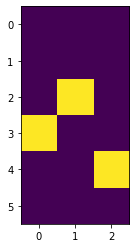

tensor([3, 2, 4, 1])


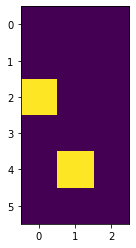

tensor([2, 3, 5, 4])


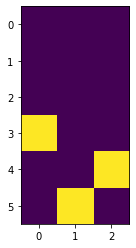

tensor([0, 3, 2, 4])


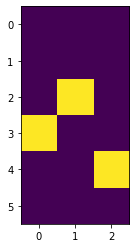

In [6]:
model = Model()
def trn(train_iter, model):
    for ex in train_iter:
        words = ex.word
        label, lengths = ex.pos
        # for x in range(words.shape[1]):
            # print(' '.join([WORD.vocab.itos[i] for i in words[:, x]]))
            # print(' '.join([POS.vocab.itos[i] for i in label[:, x]]))

        for b in range(label.shape[1]):
            model.update_a(label[:, b], lengths[b])
            model.update_b(label[:, b], words[:, b], lengths[b])
    # print(model.trnsn_prms)
    # print([(POS.vocab.itos[x[0]], POS.vocab.itos[x[1]], model.trnsn_prms[x]) for x in model.trnsn_prms])
    # print([(POS.vocab.itos[x[0]], WORD.vocab.itos[x[1]], model.emssn_prms[x]) for x in model.emssn_prms])

    transition = torch.zeros((C, C)) 
    for x in model.trnsn_prms:
        transition[x[0], x[1]] = model.trnsn_prms[x] # populate with counts
    #print(transition)
    for row in range(transition.shape[0]):
        if row!=POS.vocab.stoi['<pad>'] and row!=POS.vocab.stoi['PUNCT']: 
            transition[row, :] = Categorical(transition[row, :]).logits # normalize counts
    #print(transition.shape, '\n', transition)
    transition = transition.transpose(0, 1) # p(z_n| z_n-1) 
    #print(transition)

    init = torch.zeros(C)
    for x in range(C):
        init[x] = POS.vocab.freqs[POS.vocab.itos[x]]
    #print(init)
    init = Categorical(init).logits
    #print(init)
   
    emission = torch.zeros((C, V)) 
    for x in model.emssn_prms:  
        emission[x[0], x[1]] = model.emssn_prms[x]
    #print(emission)
    for row in range(emission.shape[0]):
        if row!=WORD.vocab.stoi['<pad>']: # p(·|PUNCT) = 1
            emission[row, :] = Categorical(emission[row, :]).logits
    #print(emission)
    emission = emission.transpose(0,1) # p(x_n| z_n)

    for ex in train_iter:
        label, lengths = ex.pos
        observations = torch.transpose(torch.LongTensor(ex.word), 0, 1).contiguous()

        #print(' '.join([WORD.vocab.itos[i] for i in words[:, 0]]))
        print(label[:, 0])
        # print(' '.join([POS.vocab.itos[i] for i in label[:, 0]]))

        out = HMM(transition, emission, init, observations, lengths=lengths) # CxC, VxC, C, bxN
        #print(out.argmax.shape) # b x (N-1) x C x C
        #print(3, out.argmax[0])
        #print(4, out.argmax[0].sum(-1))
        show_chain(out.argmax[0])
        plt.show()

trn(train_iter, model)